#### The EfficentNet model

Using effent because it should later run on edge AI device.

In [1]:
from keras.models import Model
from keras.layers import *
from keras.activations import *
from keras.callbacks import *
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, InputLayer, Conv2D, MaxPool2D, Flatten, Dropout, Activation
from tensorflow.keras.layers import BatchNormalization, Rescaling, LayerNormalization

def get_post(x_in):
    x = LeakyReLU()(x_in)
    x = BatchNormalization()(x)
    return x

def get_block(x_in, ch_in, ch_out):
    x = Conv2D(ch_in,
               kernel_size=(1, 1),
               padding='same',
               use_bias=False)(x_in)
    x = get_post(x)

    x = DepthwiseConv2D(kernel_size=(1, 3), padding='same', use_bias=False)(x)
    x = get_post(x)
    x = MaxPool2D(pool_size=(2, 1),
                  strides=(2, 1))(x) # Separable pooling

    x = DepthwiseConv2D(kernel_size=(3, 1),
                        padding='same',
                        use_bias=False)(x)
    x = get_post(x)

    x = Conv2D(ch_out,
               kernel_size=(2, 1),
               strides=(1, 2),
               padding='same',
               use_bias=False)(x)
    x = get_post(x)

    return x


def Effnet(input_shape, nb_classes, include_top=True, weights=None, activation_top=None):
    x_in = Input(shape=input_shape)

    x = get_block(x_in, 32, 64)
    x = get_block(x, 64, 128)
    x = get_block(x, 128, 256)

    if include_top:
        x = Flatten()(x)
        #x = Dense(256, activation="relu")(x)
        #x = Dense(256, activation="relu")(x)
        x = Dense(nb_classes, activation=activation_top)(x)

    model = Model(inputs=x_in, outputs=x)

    if weights is not None:
        model.load_weights(weights, by_name=True)

    return model



### Utils Scripts

Various utility scripts now like label-encoding for sin/cos output.

In [2]:
import tensorflow.keras as keras
import math
import numpy as np

def class_encoding(y_train, nb_classes):
    ret = np.zeros((len(y_train), nb_classes))
    for i, y in enumerate(y_train):
        ret[i, int((y*10)-1)] = 1
    return ret

def class_decoding(y_train, nb_classes=100):
    ret = np.zeros((len(y_train), 1))
    for i, y in enumerate(y_train):
        ret[i] = (np.argmax(y)+1)/10
    return ret

def sin_cos_encoding(y_data):
    y_train = []

    for target_number in y_data:
        target_number = (target_number) / 10
        target_sin = math.sin(target_number * math.pi * 2)
        target_cos = math.cos(target_number * math.pi * 2)

        zw = np.array([target_sin, target_cos])
        y_train.append(zw)
        #print(target_number*10, round(sin_cos_encoding_revert(zw)*10,1))
    return np.array(y_train)

def sin_cos_encoding_revert(y):
    return (np.arctan2(y[0], y[1])/(2*math.pi)) % 1

In [3]:
class_decoding([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], 100)[0]

array([1.5])

#### Augmentation functions

In [4]:
## https://medium.com/@fanzongshaoxing/adjust-local-brightness-for-image-augmentation-8111c001059b

import cv2
import numpy as np
import random
from scipy.stats import norm
import cv2
import random
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def generate_spot_light_mask(mask_size,
                             position=None,
                             max_brightness=255,
                             min_brightness=0,
                             mode="gaussian",
                             linear_decay_rate=None,
                             speedup=False):
    """
    Generate decayed light mask generated by spot light given position, direction. Multiple spotlights are accepted.
    Args:
        mask_size: tuple of integers (w, h) defining generated mask size
        position: list of tuple of integers (x, y) defining the center of spotlight light position,
                  which is the reference point during rotating
        max_brightness: integer that max brightness in the mask
        min_brightness: integer that min brightness in the mask
        mode: the way that brightness decay from max to min: linear or gaussian
        linear_decay_rate: only valid in linear_static mode. Suggested value is within [0.2, 2]
        speedup: use `shrinkage then expansion` strategy to speed up vale calculation
    Return:
        light_mask: ndarray in float type consisting value from max_brightness to min_brightness. If in 'linear' mode
                    minimum value could be smaller than given min_brightness.
    """
    if position is None:
        position = [(random.randint(0, mask_size[0]), random.randint(0, mask_size[1]))]
    if linear_decay_rate is None:
        if mode == "linear_static":
            linear_decay_rate = random.uniform(0.25, 1)
    assert mode in ["linear", "gaussian"], \
        "mode must be linear_dynamic, linear_static or gaussian"
    mask = np.zeros(shape=(mask_size[1], mask_size[0]), dtype=np.float32)
    if mode == "gaussian":
        mu = np.sqrt(mask.shape[0]**2+mask.shape[1]**2)
        dev = mu / 3.5
        mask = _decay_value_radically_norm_in_matrix(mask_size, position, max_brightness, min_brightness, dev)
    mask = np.asarray(mask, dtype=np.uint8)
    # add median blur
    mask = cv2.medianBlur(mask, 5)
    mask = 255 - mask
    # cv2.imshow("mask", mask)
    # cv2.waitKey(0)
    return mask

def _decay_value_radically_norm_in_matrix(mask_size, centers, max_value, min_value, dev):
    """
    _decay_value_radically_norm function in matrix format
    """
    center_prob = norm.pdf(0, 0, dev)
    x_value_rate = np.zeros((mask_size[1], mask_size[0]))
    for center in centers:
        coord_x = np.arange(mask_size[0])
        coord_y = np.arange(mask_size[1])
        xv, yv = np.meshgrid(coord_x, coord_y)
        dist_x = xv - center[0]
        dist_y = yv - center[1]
        dist = np.sqrt(np.power(dist_x, 2) + np.power(dist_y, 2))
        x_value_rate += norm.pdf(dist, 0, dev) / center_prob
    mask = x_value_rate * (max_value - min_value) + min_value
    mask[mask > 255] = 255
    return mask



def add_spot_light(image, light_position=None, max_brightness=255, min_brightness=0,
                   mode='gaussian', linear_decay_rate=None, transparency=None):
    """
    Add mask generated from spot light to given image
    """
    if transparency is None:
        transparency = random.uniform(0.2, 0.75)
    frame = image
    height, width, _ = frame.shape
    hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
    mask = generate_spot_light_mask(mask_size=(width, height),
                                    position=light_position,
                                    max_brightness=max_brightness,
                                    min_brightness=min_brightness,
                                    mode=mode,
                                    linear_decay_rate=linear_decay_rate)
    hsv[:, :, 2] = hsv[:, :, 2] * transparency + mask * (1 - transparency)
    frame = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
    frame[frame > 255] = 255
    frame = np.asarray(frame, dtype=np.uint8)
    return frame



def invert(imagem):
    if (random.getrandbits(1)):
        return (255)-imagem
    else:
        return imagem
        
def blur(img):
    k = random.randint(0,3)
    if (k>2):
        return (cv2.blur(img,(k,k)))
    else:
        return img



def preprocessing(img):
    if (random.getrandbits(1)):
        img = blur(img)
    if (random.randint(0, 9)<3):
        img = add_spot_light(img)
    img = invert(img)
    
    return img


Shift_Range = 0#2 # px
Brightness_Range = [0.4,0.9]
Rotation_Angle = 5
ZoomRange_Out = 0#0.2
ZoomRange_In = 0#0.1
ShearRange= 2
Channel_Shift=0#20
Blur = 5

def augmentation(x, y, Batch_Size = 32):
    datagen = ImageDataGenerator(width_shift_range=Shift_Range, 
                             height_shift_range=Shift_Range,
                             brightness_range=Brightness_Range,
                             zoom_range=[1-ZoomRange_In, 1+ZoomRange_Out],
                             rotation_range=Rotation_Angle,
                             #channel_shift_range=Channel_Shift,
                             fill_mode='nearest',
                             shear_range=ShearRange,
                             preprocessing_function=preprocessing)
    return datagen.flow(x, y, batch_size=Batch_Size)
    


#### Plot functions

In [5]:
import matplotlib.pyplot as plt
import numpy as np

def plot_dataset(images, labels, columns=12, rows=5):

    fig = plt.figure(figsize=(18, 10))
    columns = 12
    rows = 5

    for i in range(1, columns*rows +1):
        if (i>len(labels)):
            break
        fig.add_subplot(rows, columns, i)
        plt.axis("off")
        plt.title(labels[i-1])  # set title
        plt.imshow((images[i-1]), aspect='auto')
        plt.tight_layout()
    plt.show()

def plot_dataset_it(data_iter, columns=12, rows=5):

    fig = plt.figure(figsize=(18, 10))
    columns = 12
    rows = 5

    for i in range(1, columns*rows +1):
        img, label = data_iter.next()
        fig.add_subplot(rows, columns, i)
        plt.axis("off")
        plt.title((np.argmax(label[0])+1)/10)  # set title
        plt.imshow((img[0].astype(int)))
    plt.show()

def plot_acc_loss(history, modelname="modelname"):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.suptitle(modelname)
    fig.set_figwidth(15)

    if "loss" in history.history:
        ax1.plot(history.history['loss'])
    if "accuracy" in history.history:
        ax2.plot(history.history['accuracy'])
    if "val_loss" in history.history:
        ax1.plot(history.history['val_loss'])
    if "val_accuracy" in history.history:
        ax2.plot(history.history['val_accuracy'])
    if "student_loss" in history.history:
        ax1.plot(history.history['student_loss'])
    if "sparse_categorical_accuracy" in history.history:
        ax2.plot(history.history['sparse_categorical_accuracy'])
    if "val_sparse_categorical_accuracy" in history.history:
        ax2.plot(history.history['val_sparse_categorical_accuracy'])
    if "student_accuracy" in history.history:
        ax2.plot(history.history['student_accuracy'])
    if "val_student_accuracy" in history.history:
        ax2.plot(history.history['val_student_accuracy'])
    if "distillation_loss" in history.history:
        ax1.plot(history.history['distillation_loss'])

    ax1.set_title('model loss')
    ax1.set_ylabel('loss')
    ax1.set_xlabel('epoch')
    ax2.set_ylabel('accuracy')
    ax2.set_xlabel('epoch')
    ax1.legend(['train','eval'], loc='upper left')
    axes = plt.gca()
    axes.set_ylim([0.92,1])
    plt.show()

def plot_test_divergence(out_sin, out_cos):
    plt.plot(out_sin)
    plt.plot(out_cos)
    plt.title('Result')
    plt.ylabel('value')
    plt.xlabel('#Picture')
    plt.legend(['sin', 'cos'], loc='lower left')
    plt.show()

#### Data loading function

In [6]:
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.utils import shuffle

def tmnist_percentals():
    x_train = np.empty((1,32,20,3))
    y_train = np.empty((1,1))
    for i in range(28):

        dataset_url = "/kaggle/input/percentile-tmnist-for-electric-meters/TMNIST_PERCENTAL_"+str((i+1)*1000)+"_Data.csv"
        data = pd.read_csv(dataset_url, index_col=False)
        #print(data.head())
        y_tmnist = data[['labels']]
        X = data.drop({'labels','names'},axis=1)

        #print(data)
        X_images = (255-(X.values.reshape(-1,28,28,1)))/255.
        x_tmnist = tf.image.grayscale_to_rgb(tf.convert_to_tensor(X_images))
        x_tmnist = tf.image.resize(x_tmnist, (32,20))

        x_train = np.concatenate((x_tmnist, x_train))
        y_train = np.concatenate((y_tmnist.values, y_train))
        #print(x_tmnist.shape, np.array(y_tmnist).shape)
    return shuffle(x_train,  y_train)


#### 

In [7]:
########### Basic Parameters for Running: ################################
    
Training_Percentage = 0.2           
Epoch_Anz = 50
nb_classes = 100                     # move to 1. step
input_shape = (32, 20,3)
Batch_Size = 32

##########################################################################


### Load data

2022-05-05 11:24:15.283795: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
/opt/conda/lib/python3.7/site-packages/matplotlib/text.py:1223: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


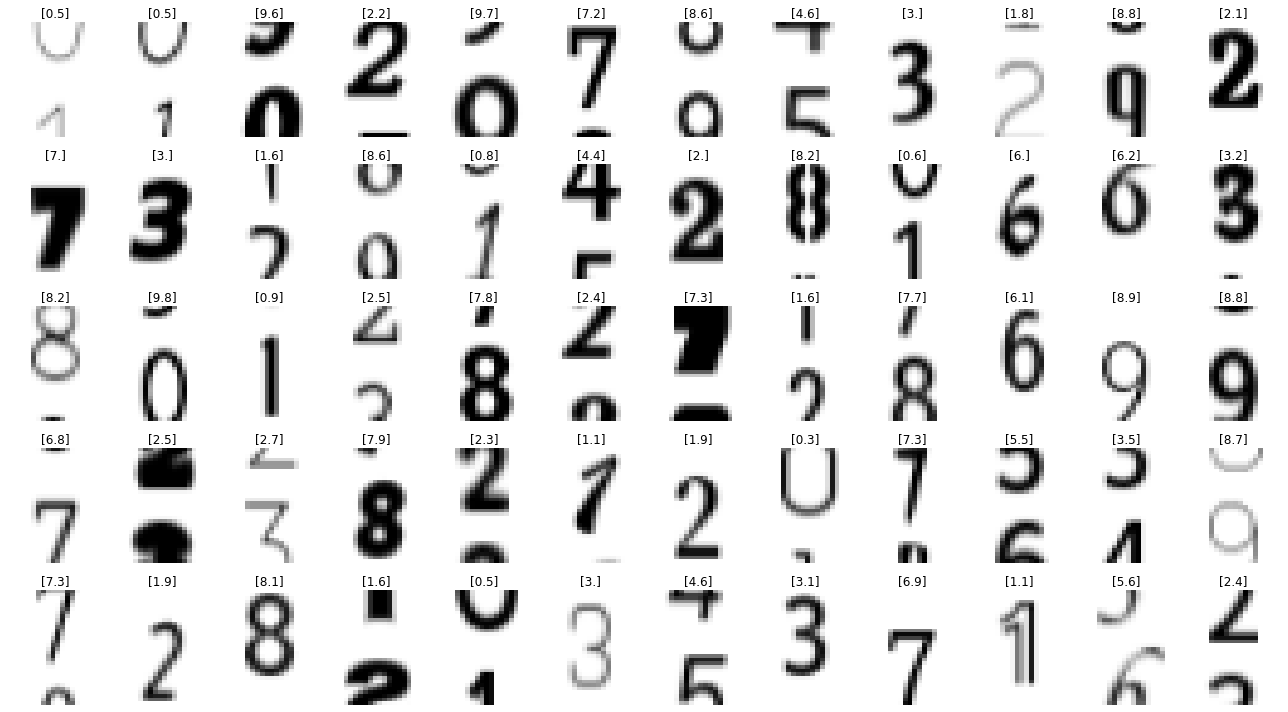

In [8]:
x_train, y_train = tmnist_percentals()
plot_dataset(x_train, y_train)

y_train = class_encoding(y_train, nb_classes)

### Augmentation

So it looks more like real meter digits

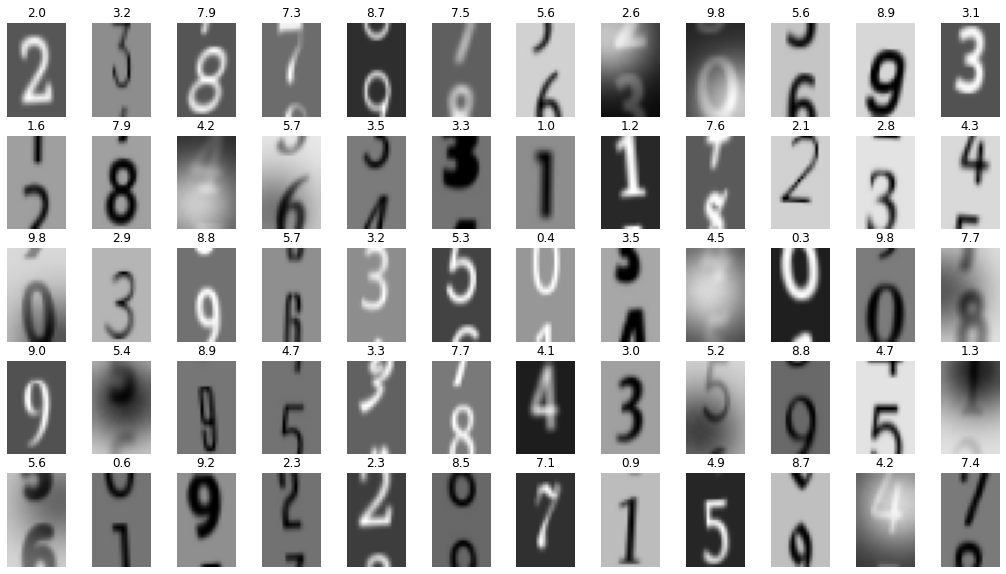

In [9]:
import numpy as np
from sklearn.model_selection import train_test_split

# Split train and validation data 
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=Training_Percentage)

train_iterator = augmentation(x_train, y_train)
validation_iterator = augmentation(x_test, y_test)

plot_dataset_it(train_iterator)       


### The Model

Is an small EfficientNet like model with 3 Dense layer at top. The last layer uses **tanh** as activation.

In [10]:
import tensorflow as tf

model = Effnet(input_shape, nb_classes, activation_top=None)

model.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True), 
              optimizer="adam", metrics = ["accuracy"])

2022-05-05 11:25:44.642905: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50
7000/7000 - 559s - loss: 0.2855 - accuracy: 0.9294 - val_loss: 0.1309 - val_accuracy: 0.9663
Epoch 2/50
7000/7000 - 582s - loss: 0.0940 - accuracy: 0.9739 - val_loss: 0.0808 - val_accuracy: 0.9767
Epoch 3/50
7000/7000 - 557s - loss: 0.0659 - accuracy: 0.9810 - val_loss: 0.0641 - val_accuracy: 0.9822
Epoch 4/50
7000/7000 - 554s - loss: 0.0520 - accuracy: 0.9845 - val_loss: 0.0584 - val_accuracy: 0.9836
Epoch 5/50
7000/7000 - 556s - loss: 0.0452 - accuracy: 0.9865 - val_loss: 0.0530 - val_accuracy: 0.9852
Epoch 6/50
7000/7000 - 552s - loss: 0.0398 - accuracy: 0.9880 - val_loss: 0.0535 - val_accuracy: 0.9855
Epoch 7/50
7000/7000 - 564s - loss: 0.0364 - accuracy: 0.9890 - val_loss: 0.0478 - val_accuracy: 0.9863
Epoch 8/50
7000/7000 - 571s - loss: 0.0335 - accuracy: 0.9895 - val_loss: 0.0458 - val_accuracy: 0.9871
Epoch 9/50
7000/7000 - 578s - loss: 0.0308 - accuracy: 0.9906 - val_loss: 0.0427 - val_accuracy: 0.9879
Epoch 10/50
7000/7000 - 566s - loss: 0.0285 - accuracy: 0.9910 -

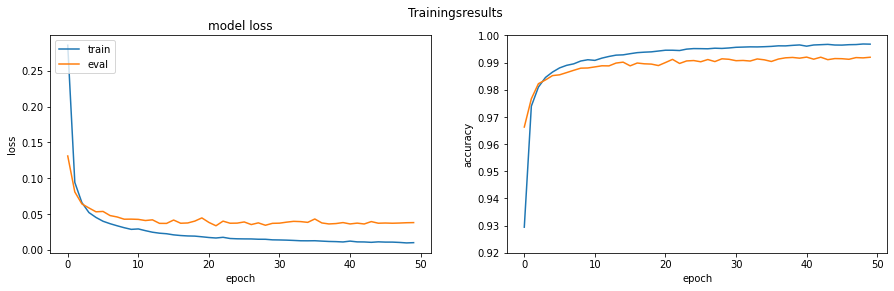

In [11]:
history = model.fit(train_iterator, 
                validation_data=validation_iterator, 
                batch_size=Batch_Size, 
                epochs = 50,
                verbose=2)

plot_acc_loss(history, "Trainingsresults")

model.save("eff100.h5")

### Verfify the training

Now a few (5000) images from validation set will be used to evaluate the model.

All the first (max 30) false predicted images will be shown.

If all fine the predictions will be shown in a diagram and it should be a sinus and cosinus wave. The glitches are the false predictions.

Exp: [[2.6]] Pred: [2.5]
Exp: [[6.5]] Pred: [0.5]
Exp: [[3.]] Pred: [2.9]
Exp: [[6.8]] Pred: [0.8]
Exp: [[7.2]] Pred: [7.3]
Exp: [[4.3]] Pred: [4.4]
Exp: [[1.8]] Pred: [8.9]
Exp: [[0.3]] Pred: [4.3]
Exp: [[8.7]] Pred: [9.7]
Exp: [[1.1]] Pred: [7.1]
Exp: [[0.1]] Pred: [3.1]
Exp: [[9.]] Pred: [1.]
Exp: [[6.8]] Pred: [0.8]
Exp: [[7.2]] Pred: [1.2]
Exp: [[0.5]] Pred: [0.6]
Exp: [[0.3]] Pred: [4.3]
Exp: [[6.]] Pred: [5.]
Exp: [[5.5]] Pred: [9.5]
Exp: [[9.3]] Pred: [8.3]
Exp: [[0.6]] Pred: [3.8]
Exp: [[7.5]] Pred: [1.5]
Exp: [[1.3]] Pred: [7.3]
Exp: [[3.4]] Pred: [5.4]
Exp: [[6.5]] Pred: [0.5]
Exp: [[8.4]] Pred: [8.5]
Exp: [[3.]] Pred: [9.]
Exp: [[5.4]] Pred: [3.4]
Exp: [[7.]] Pred: [7.1]
Exp: [[4.9]] Pred: [5.9]
Exp: [[2.7]] Pred: [4.7]
Exp: [[9.2]] Pred: [9.3]
Exp: [[9.]] Pred: [9.1]
Exp: [[1.]] Pred: [7.]
Exp: [[3.9]] Pred: [4.]
Exp: [[8.2]] Pred: [3.2]
Exp: [[6.9]] Pred: [1.9]
Exp: [[1.8]] Pred: [1.9]
Exp: [[2.8]] Pred: [7.8]
Exp: [[1.9]] Pred: [2.]
Exp: [[7.9]] Pred: [2.9]
Exp: [[1.1]] 

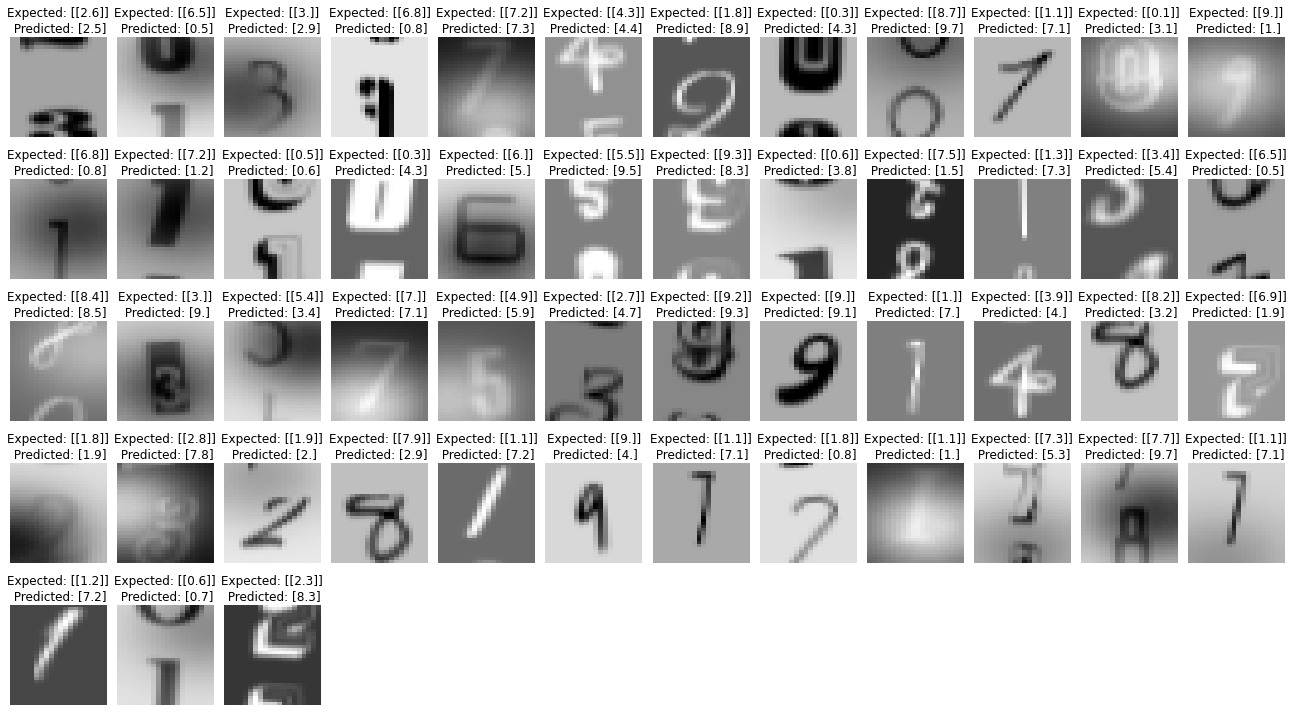

In [12]:
import numpy as np
from operator import itemgetter

res = []
stat_Anz = []
stat_Abweichung = []
false_img = []
false_label = []
i = 0
deviation_max_list = 0.05
test_count = 5000

for i in range(100):
    stat_Anz.append(0)
    stat_Abweichung.append(0)

for x_test, y_test in validation_iterator:
    if (test_count<0):
        break
    test_count = test_count - Batch_Size
           
    for (x, y) in zip(x_test, y_test):
            
        target = class_decoding([y])
        classes = model.predict(x.reshape(1,32,20,3))
        
        
        out_target = class_decoding(classes)[0]

                       
        if target != out_target:
            lbl_text = "Expected: " + str(target) + "\n Predicted: " + str(out_target)
            print("Exp: " + str(target) + " Pred: " + str(out_target))
            false_img.append(x)
            false_label.append(lbl_text)
    
for i in range(100):
    if (stat_Anz[i] != 0):
        stat_Abweichung[i] = stat_Abweichung[i] / stat_Anz[i]

res = np.asarray(res)
res_step_1 = res
print(f"{len(false_label)} false predicted")
plot_dataset(np.array(false_img).astype(np.uint8), false_label, columns=11, rows=3)
#res = sorted(res, key=itemgetter(0))
#plot_test_divergence(res[:,3], res[:,4])
